# TP53 Methods - Sweep of All Proteins
## This was our second analysis, used to discover potential unknown interactions

### Standard imports, including CPTAC package

In [1]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


### Set up initial dataframes and variables

In [9]:
gene='TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()

# A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]

# Get a list of patient identifiers for those who have mutations in the hotspot
hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']
hotspot_patients

586      S001
1318     S006
1404     S008
4019     S015
4089     S016
4736     S020
44973    S071
45005    S072
46785    S082
49867    S096
49948    S097
Name: Clinical_Patient_Key, dtype: object

### Find number of patients with TP53 mutations in/outside of hotspot

In [3]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p53_mutated = somatic.loc[somatic['Gene'] == 'TP53']

# This naturally includes a value that is 'NA' so we subtract 1
# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p53_mutated['Clinical_Patient_Key'])) - 1
print("Total number of patients with mutations: " + str(num_mutated))

Mutations inside hotspot: 11
Total number of patients with mutations: 23


## TP53 trans effects on all proteins (proteomic analysis)

### All mutations vs. cancer wildtype

In [4]:
significant_all_mut_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(proteomics.columns)

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest if there is enough data for that protein
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_all_mut_wt[protein] = ttest[1]
            
significant_all_mut_wt

{'AATF': 1.266048048071304e-06,
 'ABCF1': 5.6815313724393495e-08,
 'ABR': 8.545863737744414e-07,
 'ABT1': 8.538181896374406e-08,
 'ADNP': 2.0199807413636665e-06,
 'AES': 2.9092702779791657e-06,
 'AGR2': 4.047096945897462e-06,
 'AKAP8L': 3.6626859975505244e-06,
 'ALG2': 1.743857025038544e-08,
 'ANKIB1': 3.174302540714209e-06,
 'ANLN': 4.155729958309228e-06,
 'AP3B1': 1.2045656525146858e-06,
 'APPL2': 3.959976983996512e-06,
 'ARFIP1': 4.1698785326929203e-08,
 'ARFIP2': 4.042384258965761e-09,
 'ARHGAP26': 1.202249321462185e-06,
 'ATAD2': 3.992881881924542e-08,
 'BCAM': 4.2535370911230496e-07,
 'BIN3': 3.884962628773553e-06,
 'BOP1': 1.0234558051139974e-06,
 'BUB1': 1.5183480312352683e-06,
 'BUB1B': 1.8228837101342786e-06,
 'C9orf152': 2.7150423532337168e-06,
 'CA8': 2.062438486757319e-08,
 'CAD': 1.373806071970896e-08,
 'CBS': 1.9780532143043267e-07,
 'CD40': 3.326166839720353e-06,
 'CDC20': 5.664841725700304e-07,
 'CDKAL1': 8.853602832660135e-09,
 'CDYL': 2.5741547204253434e-06,
 'CEBPZ'

### Mutations outside of the hotspot vs. cancer wildtype

In [5]:
significant_nonhspt_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(proteomics.columns)

# Go through every protein in our proteomics dataframe
for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest if there is enough data for that protein
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_nonhspt_wt[protein] = ttest[1]
            
significant_nonhspt_wt

{'AATF': 2.271160541378623e-06,
 'ABCF1': 7.956425028703259e-07,
 'ADCK5': 8.189361630957735e-07,
 'ALG2': 2.0668934289128748e-07,
 'BCAM': 4.505557363715261e-06,
 'CDKAL1': 1.972879342037777e-06,
 'CEBPZ': 1.0479678547298773e-06,
 'COPS4': 4.060147919415321e-06,
 'CSE1L': 1.853238564488548e-06,
 'DLGAP5': 4.513234600475197e-06,
 'FAM120A': 9.023674874020406e-07,
 'FAS': 1.919566485004978e-06,
 'FXR1': 1.8538782198109746e-06,
 'GEMIN2': 8.897282510960702e-08,
 'GMPS': 1.923438895158346e-06,
 'GRB7': 9.975766002561324e-07,
 'GXYLT1': 8.303114799412363e-07,
 'HEATR1': 2.1413351821836567e-06,
 'HELZ2': 3.634293685170195e-06,
 'KIF13B': 6.844054395841364e-07,
 'LSG1': 1.6794881696470295e-09,
 'MASTL': 2.7843892383276583e-06,
 'MEST': 2.796902874406813e-07,
 'MTHFD2': 1.8684494176332288e-07,
 'MYO5C': 2.7952448299354863e-06,
 'NGDN': 1.420479474106042e-07,
 'NMRAL1': 1.440823992695973e-06,
 'NOL10': 4.873535882083441e-09,
 'NPDC1': 1.0494485383830662e-06,
 'PRRC2A': 1.570218305301509e-06,
 

### Hotspot mutations vs. cancer wildtype

In [19]:
significant_htspt_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(proteomics.columns)

for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_htspt_wt[protein] = ttest[1]
            
significant_htspt_wt

{'ABT1': 1.8717179476980943e-06,
 'AKAP8L': 4.535598062812488e-06,
 'ARFIP1': 3.4031295680378384e-06,
 'ARFIP2': 1.936629039801604e-06,
 'AURKA': 2.218884225024604e-06,
 'CAD': 1.385703150141922e-07,
 'CDK11B': 7.563488404468304e-07,
 'CEBPZ': 3.6269074655231765e-06,
 'CHD4': 4.474132334204877e-06,
 'CIP2A': 4.09191979621314e-08,
 'CMSS1': 1.8339904953878133e-07,
 'CMTR1': 1.4797166262784651e-08,
 'DDX27': 8.317723844978244e-07,
 'DDX52': 1.2717278314195844e-07,
 'DLGAP5': 1.0617718897312778e-07,
 'DNTTIP2': 3.3080747440229025e-06,
 'ECT2': 1.67043202717345e-06,
 'EIF2AK2': 1.778453837866272e-08,
 'ESF1': 2.8780144617612393e-08,
 'FBXO22': 1.6685015291272188e-06,
 'FXR1': 1.4730504996676262e-07,
 'GALNT10': 2.318970885102107e-06,
 'GPATCH1': 3.9330476690959214e-08,
 'GRB7': 3.6196771054454553e-07,
 'HEATR1': 1.2489733976455246e-06,
 'HELZ2': 1.6543004957610314e-07,
 'HMCES': 5.829971448449606e-07,
 'IFIT2': 9.486251312386158e-09,
 'IRF2BPL': 1.0764195688185132e-06,
 'JADE3': 9.68629775

### Hotspot mutations vs other mutations

In [8]:
significant_htspt_nonhtspt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(proteomics.columns)

for protein in proteomics.columns:
    if (protein != 'idx') and (protein != gene):
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
        if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_htspt_nonhtspt[protein] = ttest[1]
            
significant_htspt_nonhtspt

{}

## Identify the proteins for which hotspot mutations make a difference but other mutations do not

In [22]:
# Find proteins that are in the significant_htspt list but NOT in the significant_nonhotspot list
only_htspt = {k:v for k,v in significant_htspt_wt.items() if k not in significant_nonhspt_wt}
# Of these proteins, test for ones where there is a significant difference betwenn hotspot and non-hotspot mutations

hotspot_difference = {}
hotspot_cutoff = 0.05
for protein, pval in only_htspt.items():
    # Create dataframe with mutation status of TP53 with proteomics of the given protein
    p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
    # Create a column showing the location of TP53 mutation
    p53_mutations_protein['Within_Hotspot'] = False
    p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
    p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
    p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
    # Perform the ttest
    hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
    other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
    if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
    ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
    # Print significant values
    if ttest[1] <= hotspot_cutoff:
        hotspot_difference[protein] = ttest[1]

hotspot_difference

{'GALNT10': 0.04038743907780136,
 'NOL7': 0.035044033265370374,
 'OGFR': 0.03671047266388255,
 'OSBPL2': 0.01861471388095648,
 'PKN1': 0.046577854844251664,
 'PRPF39': 0.007008675580576033,
 'RTF2': 0.030943354105481925,
 'XRN1': 0.034083340622258235,
 'XRN2': 0.027453933276874908}

## Plot these proteins

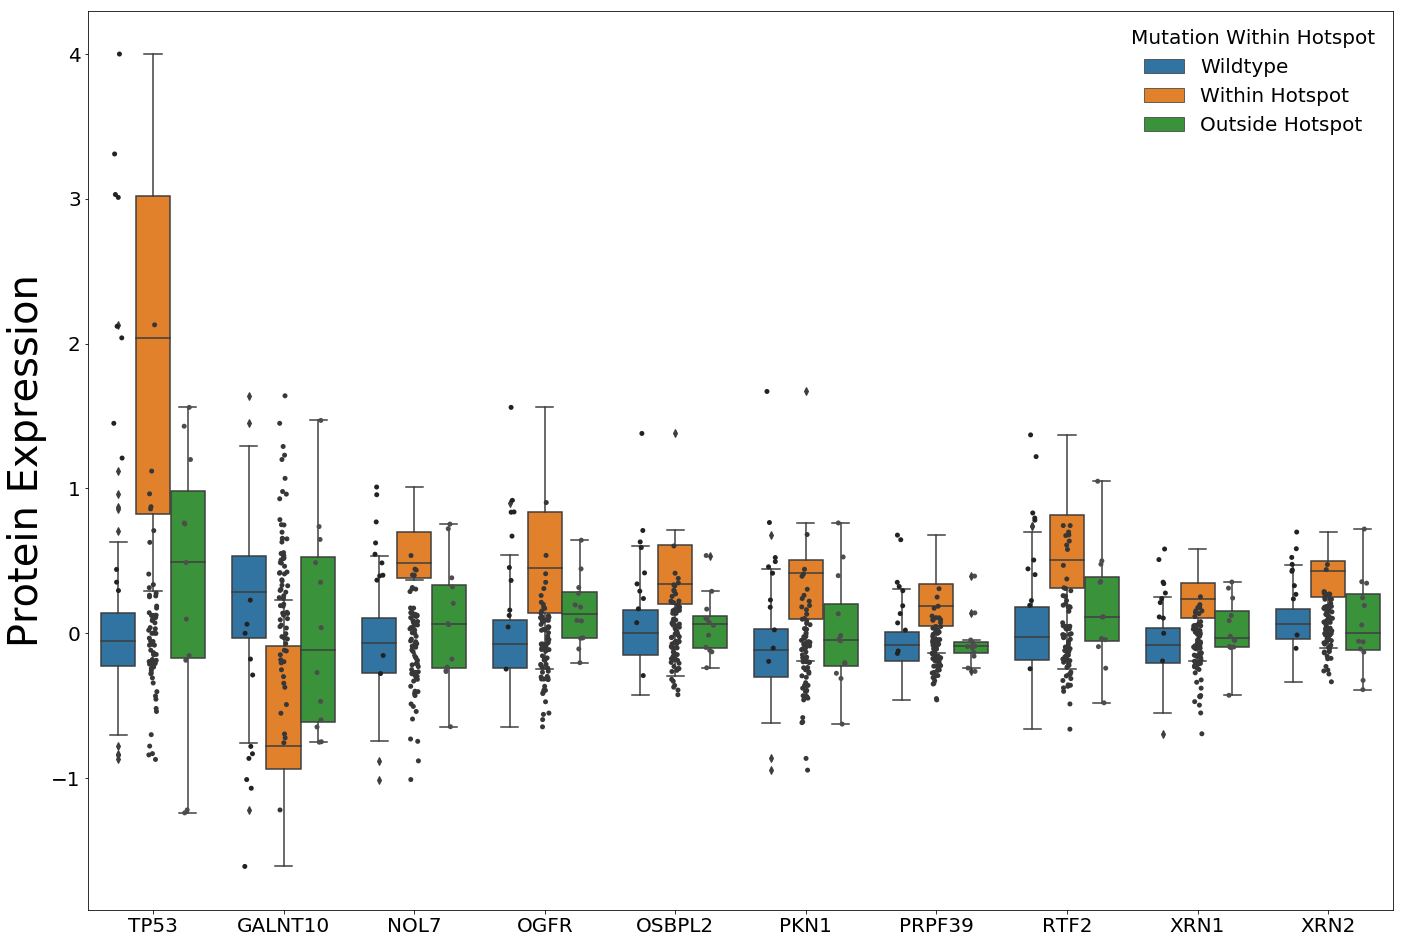

In [38]:
proteins_to_plot = []
for k, v in hotspot_difference.items():
    proteins_to_plot.append(k)

plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][[gene, 'Mutation']]
for protein in proteins_to_plot:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
    plotdf = plotdf.join(proteindf)

plotdf['Within_Hotspot'] = 'Outside Hotspot'
plotdf.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
plotdf.loc[plotdf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
plotdf = pd.melt(plotdf, id_vars = ['Mutation', 'Within_Hotspot'], var_name = 'Protein', value_name = 'Proteomics')
plotdf = plotdf.dropna(axis = 0)

a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Proteomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Within_Hotspot', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Expression', fontsize='40')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='Mutation Within Hotspot', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))